In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [4]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [5]:
# Error indice
indice_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [6]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indice_beginning_0_all] = 0

In [7]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [8]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [9]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals_all_100206*1e-3)

In [10]:
normalized_scan_100206_full = scan_100206_long_no_background / S0_100206

In [11]:
normalized_scan_100206_full.shape

(935442, 288)

In [32]:
rand_half_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 9))

In [33]:
rand_half_bval_indice_100206

array([ 32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 208, 209, 210, 211, 212, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 222, 223, 256, 257, 258, 259, 260, 261,
       262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274,
       275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287])

In [34]:
bvals_100206_half = bvals_all_100206[rand_half_bval_indice_100206]*1e-3

In [35]:
normalized_scan_100206_half = normalized_scan_100206_full[:, rand_half_bval_indice_100206]

In [36]:
big_b_indice_100206_half = np.where(bvals_100206_half != 0.005)[0]

In [37]:
big_b_indice_100206_half

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142])

In [38]:
bvals_100206_half_no_b5 = bvals_100206_half[big_b_indice_100206_half]

In [39]:
normalized_scan_100206_half_no_b5 = normalized_scan_100206_half[:, big_b_indice_100206_half]

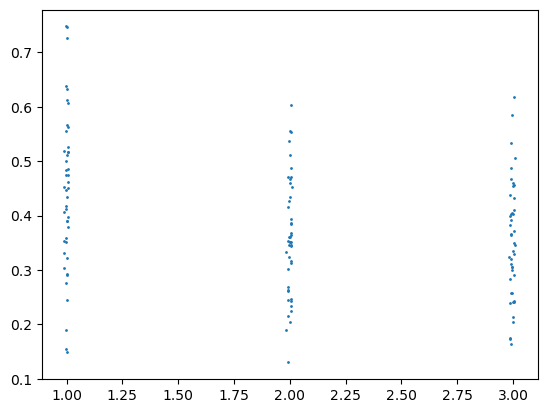

In [40]:
plt.plot(bvals_100206_half_no_b5, normalized_scan_100206_half_no_b5[42,:], "o", markersize = 1)

ANN

In [41]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [42]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [43]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [44]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n_100206_half = n_100206_all[:, rand_half_bval_indice_100206]

In [45]:
print(n_100206_half.shape)
print(big_b_indice_100206_half)

(3, 143)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142]


In [46]:
n_100206_half_no_b5 = n_100206_half[:,big_b_indice_100206_half].T
print(n_100206_half_no_b5.shape)

b_values_100206_half_no_b5 = torch.FloatTensor(bvals_100206_half_no_b5)
gradient_directions_100206_half_no_b5 = torch.FloatTensor(n_100206_half_no_b5)

net = BallStickNet(gradient_directions_100206_half_no_b5, b_values_100206_half_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

(134, 3)


In [47]:
batch_size = 128
num_batches = len(normalized_scan_100206_half_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_half_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [49]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.92it/s]


Loss: 397.18317478802055
Average Loss: 0.05434909343021627
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.61it/s]


Loss: 397.14957744954154
Average Loss: 0.05434449609325965
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.60it/s]


Loss: 397.08646588237025
Average Loss: 0.05433586013716068
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.98it/s]


Loss: 397.0615483119618
Average Loss: 0.054332450507931285
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.76it/s]


Loss: 397.099308881443
Average Loss: 0.05433761752619636
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.98it/s]


Loss: 397.1120214101393
Average Loss: 0.05433935706214276
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.79it/s]


Loss: 397.1300071571022
Average Loss: 0.054341818165996474
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.03it/s]


Loss: 397.06668121623807
Average Loss: 0.054333152875785176
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.60it/s]


Loss: 397.0063709113747
Average Loss: 0.054324900234178256
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.47it/s]


Loss: 397.0571894447785
Average Loss: 0.0543318540564831
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 1


  2%|███▎                                                                                                                                                          | 155/7308 [00:02<00:41, 172.52it/s]

X_batch: 
torch.Size([128, 134])
tensor([[0.1194, 0.3545, 0.2365,  ..., 0.5061, 0.1942, 0.1670],
        [0.0852, 0.0915, 0.1179,  ..., 0.1146, 0.1494, 0.0766],
        [0.3291, 0.4460, 0.2528,  ..., 0.4148, 0.2390, 0.3362],
        ...,
        [0.1474, 0.2901, 0.1500,  ..., 0.2683, 0.1982, 0.1354],
        [0.1931, 0.4617, 0.3445,  ..., 0.4799, 0.2135, 0.1213],
        [0.0708, 0.1874, 0.0764,  ..., 0.1806, 0.0799, 0.0510]])
X_pred: 
torch.Size([128, 134])
tensor([[0.1068, 0.4026, 0.2158,  ..., 0.4203, 0.2248, 0.1213],
        [0.1119, 0.1470, 0.1031,  ..., 0.1430, 0.1142, 0.1116],
        [0.2622, 0.4498, 0.2765,  ..., 0.4282, 0.3139, 0.2522],
        ...,
        [0.1437, 0.2894, 0.1598,  ..., 0.2916, 0.1753, 0.1504],
        [0.1673, 0.4424, 0.2573,  ..., 0.4548, 0.2457, 0.1794],
        [0.0536, 0.1903, 0.0675,  ..., 0.1859, 0.0700, 0.0521]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.84it/s]


Loss: 397.0381440613419
Average Loss: 0.05432924795584864
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.94it/s]


Loss: 396.9892881703563
Average Loss: 0.05432256269435636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.19it/s]


Loss: 396.9847415036056
Average Loss: 0.054321940545102025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.23it/s]


Loss: 397.0329624917358
Average Loss: 0.05432853892880895
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.64it/s]


Loss: 396.95031782612205
Average Loss: 0.05431723013493733
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.80it/s]


Loss: 397.0637512165122
Average Loss: 0.054332751945335545
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.30it/s]


Loss: 397.05972243566066
Average Loss: 0.05433220066169413
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.35it/s]


Loss: 396.9539308375679
Average Loss: 0.05431772452621345
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.11it/s]


Loss: 397.00656174472533
Average Loss: 0.05432492634711622
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.97it/s]


Loss: 396.9695216033142
Average Loss: 0.05431985790959417
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.24it/s]


Loss: 396.9550768358167
Average Loss: 0.05431788134042374
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.29it/s]


Loss: 396.90540669020265
Average Loss: 0.05431108465930523
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.47it/s]


Loss: 396.8793521686457
Average Loss: 0.054307519453837674
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.89it/s]


Loss: 396.8734616669826
Average Loss: 0.05430671341912734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.52it/s]


Loss: 396.87007799884304
Average Loss: 0.05430625041035072
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.01it/s]


Loss: 396.8502415716648
Average Loss: 0.05430353606618293
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.71it/s]


Loss: 396.91995481867343
Average Loss: 0.05431307537201333
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.00it/s]


Loss: 397.00840923702344
Average Loss: 0.05432517915120737
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.69it/s]


Loss: 396.91230054572225
Average Loss: 0.05431202798928876
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.31it/s]


Loss: 396.91138846823014
Average Loss: 0.05431190318393954
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.63it/s]


Loss: 396.8674412406981
Average Loss: 0.05430588960600686
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.14it/s]


Loss: 396.9312271580566
Average Loss: 0.05431461783771984
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.46it/s]


Loss: 396.90536518301815
Average Loss: 0.05431107897961387
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.96it/s]


Loss: 396.8271683822386
Average Loss: 0.054300378815303585
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.14it/s]


Loss: 396.85535043338314
Average Loss: 0.054304235144141094
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.83it/s]


Loss: 396.80275314091705
Average Loss: 0.054297037922949785
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.90it/s]


Loss: 396.77744585392065
Average Loss: 0.054293574966327404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.26it/s]


Loss: 396.8875456764363
Average Loss: 0.05430864062348608
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.22it/s]


Loss: 396.9513359803241
Average Loss: 0.0543173694554357
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.57it/s]


Loss: 396.8869613308925
Average Loss: 0.0543085606637784
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.93it/s]


Loss: 396.8018901962787
Average Loss: 0.054296919840760634
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.71it/s]


Loss: 396.8475515774917
Average Loss: 0.05430316797721561
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.55it/s]


Loss: 396.8453539472539
Average Loss: 0.054302867261529
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.28it/s]


Loss: 396.78866447880864
Average Loss: 0.05429511008193878
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.62it/s]


Loss: 396.74106122669764
Average Loss: 0.05428859622697012
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.52it/s]


Loss: 396.8642071450595
Average Loss: 0.05430544706418439
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.83it/s]


Loss: 396.7314179725945
Average Loss: 0.05428727667933696
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.12it/s]


Loss: 396.81132639665157
Average Loss: 0.05429821105591839
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.39it/s]


Loss: 396.7249684189446
Average Loss: 0.0542863941459968
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.77it/s]


Loss: 396.6786879254505
Average Loss: 0.05428006129248091
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.98it/s]


Loss: 396.69375988887623
Average Loss: 0.054282123684848964
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.94it/s]


Loss: 396.78879134566523
Average Loss: 0.054295127441935584
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.84it/s]


Loss: 396.8079033631366
Average Loss: 0.05429774266052772
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.80it/s]


Loss: 396.6971582870465
Average Loss: 0.054282588709229126
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.54it/s]


Loss: 396.73158875852823
Average Loss: 0.05428730004905969
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.11it/s]


Loss: 396.77094433410093
Average Loss: 0.05429268532212656
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.00it/s]


Loss: 396.7081456289161
Average Loss: 0.05428409217691791
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.25it/s]


Loss: 396.6582774708513
Average Loss: 0.05427726840049963
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.76it/s]


Loss: 396.71075881947763
Average Loss: 0.05428444975635983
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.05it/s]


Loss: 396.65534120076336
Average Loss: 0.05427686661203658
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.71it/s]


Loss: 396.62002750486135
Average Loss: 0.05427203441500566
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.24it/s]


Loss: 396.6105902453419
Average Loss: 0.05427074305491816
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.23it/s]


Loss: 396.63154410594143
Average Loss: 0.05427361030458969
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.59it/s]


Loss: 396.736212588381
Average Loss: 0.05428793275703079
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.95it/s]


Loss: 396.6620694103185
Average Loss: 0.054277787275631977
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.25it/s]


Loss: 396.5621321860235
Average Loss: 0.05426411223125664
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.57it/s]


Loss: 396.5807271981612
Average Loss: 0.05426665670472922
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.24it/s]


Loss: 396.58887076121755
Average Loss: 0.054267771040122814
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.97it/s]


Loss: 396.64541555498727
Average Loss: 0.0542755084229594
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.41it/s]


Loss: 396.5934042248409
Average Loss: 0.05426839138270949
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.46it/s]


Loss: 396.6168088039849
Average Loss: 0.05427159397974615
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.47it/s]


Loss: 396.6107707740739
Average Loss: 0.054270767757809785
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.77it/s]


Loss: 396.613606672734
Average Loss: 0.05427115581181363
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.90it/s]


Loss: 396.6175677506253
Average Loss: 0.054271697831229516
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.95it/s]


Loss: 396.57806724030524
Average Loss: 0.05426629272582174
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.52it/s]

Loss: 396.59769342374057
Average Loss: 0.05426897830100445
Done, best loss: 396.5621321860235
Done


<All keys matched successfully>

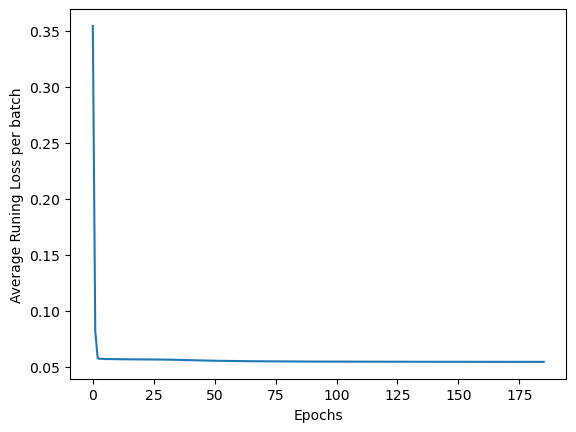

In [29]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [30]:
torch.save(final_model, 'model_100206_half_04.pt')